<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install datasets

In [57]:
from __future__ import annotations
import math, numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate


In [58]:
import logging, pickle, gzip, os, time, shutil, torch, matplotlib as mpl
from pathlib import Path

from torch import tensor, nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [59]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray'

In [60]:
logging.disable(logging.WARNING)

In [61]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [62]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [63]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [64]:
dsd = load_dataset(name)

In [65]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [66]:
x, y = ds_builder.info.features

In [67]:
x, y

('image', 'label')

In [68]:
img = train[0][x]
img

In [69]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [70]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [71]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [72]:
train['label'][:5]

[9, 0, 0, 3, 0]

In [73]:
def collate_fn(b):
  return {x: torch.stack([TF.to_tensor(o[x]) for o in b]),
          y: tensor([o[y] for o in b])}

In [74]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [75]:
def transforms(b):
  b[x] = [TF.to_tensor(o) for o in b[x]]
  return b

In [76]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [77]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [78]:
def inplace(f):
  def _f(b):
    f(b)
    return b
  return _f

In [79]:
transformi = inplace(_transformi)

In [80]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [81]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [82]:
tdfs = train.with_transform(transformi)
r = tdfs[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [83]:
d = dict(a=1, b=2, c=3)
ig = itemgetter('a', 'c')
ig(d)

(1, 3)

In [84]:
class D:
  def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [85]:
d = D()
ig(d)

(1, 3)

In [86]:
list(tdfs.features)


['image', 'label']

In [87]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [88]:
def collate_dict(ds):
  get = itemgetter(*ds.features)
  def _f(b): return get(default_collate(b))
  return _f

In [89]:
dlf = DataLoader(tdfs, batch_size=4, collate_fn=collate_dict(tdfs))
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

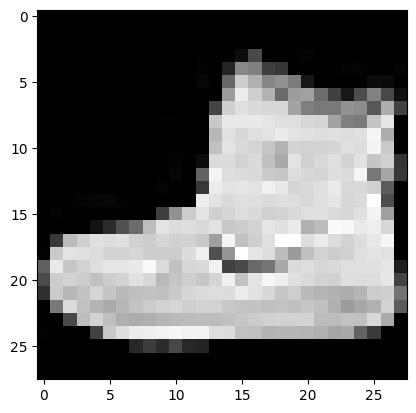

In [90]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);